# Assignment 5. Bayesian Logistic Regressian

Yizhi Zhou | 1003002396 | Apr 2, 2019

Important source of learning: 
[Bayesian Linear Regression Tutorial](https://github.com/zjost/bayesian-linear-regression/blob/master/src/bayes-regression.ipynb)
 | [Another Bayesian Demo](https://nbviewer.jupyter.org/github/MaxPoint/bayes_logistic/blob/master/notebooks/bayeslogistic_demo.ipynb)
 | [Lecture notes 1](https://www.cse.wustl.edu/~garnett/cse515t/spring_2019/files/lecture_notes/8.pdf)
 | [Lecture notes 2](https://www.inf.ed.ac.uk/teaching/courses/mlpr/2016/notes/w8a_bayes_logistic_regression_laplace.pdf)

In [152]:
%matplotlib inline
from data_utils import load_dataset
import numpy as np
from numpy import dot
import scipy as sp
from scipy.stats import multivariate_normal as Normal
from scipy.stats import bernoulli as Bernoulli
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(99)

_COLORS = ['#d6616b', '#fdae6b', '#e7ba52', '#e69fa5', '#dbdb8d']

## Utility Functions
The inputs of these functions are one or more of the followings:
   * w: (D, 1) parameter of the model
   * x: (N, D) the feature set
   * y: (N, 1) the labels corresponding to the feature set
   * var: float, variance that is specified in the priori model

In [9]:
def getSigmoidProbability(w, x):
    ''' Return: (N, ) array, each element is a float between [0, 1], the probability after passing through sigmoid
    '''
    z = np.dot(x, w)
    return 1 / (1 + np.exp(-z))

#### Performance Criteria

In [33]:
def getMarginLikelihood(w, x, y, H):
    ''' Return: negative float, the log likelihood log(P(y|x)), marginalized over w.
    This is used to compare models
    '''
    LogMargin = getLogLikelihood(w, x, y) + getLogPrior(w, var) - getLogPosteriorLaplace(w, x, H)
    return LogMargin

In [11]:
def getAccuracy(w, x, y, threshold=0.5):
    ''' Return: float between (0, 100), the percentage (%) of correct predictions, given the weight (should be wMAP)
    '''
    y_predicted = (getSigmoidProbability(w, x) >= threshold)
    accuracy = np.mean(y.T[0]==y_predicted)
    return accuracy * 100

#### Probabilities

In [274]:
def getLikelihood(w, x, y):
    return np.exp(getLogLikelihood(w, x, y))

def getPrior(w, var):
    return np.exp(getLogPrior(w, var))

def getPosterior(w, x, y, var):
    return np.exp(getLogPosterior(w, x, y, var))

def getLikelihoodNew(w, x, y):
    '''(N, ) array instead of a float. It keeps the individual likelihoods instead of multiplying them together.
    '''
    f = getSigmoidProbability(w, x)
    return f
    print('\nf:',f,'\nw:', w,'\nx:', x,'\ny:', y)
    LogLikelihood = y.T*(np.log(f)) + (1 - y.T)*(np.log(1 - f))

#### Log Probabilities

In [14]:
x = np.array([[1, 2, 3], [3, 4, 2]])
y = np.array([[1], [0]])
w = np.array([1, 2, 3])
var = 1.

In [43]:
wMAP = np.array([2,3,3])
H = getHessian(w, x, y, var)

In [34]:
def getLogLikelihood(w, x, y):
    ''' Return: float, the log likelihood of this combination of x and w returning a correct y. 
        If there're multiple datapoints, the average is taken.
    '''
    f = getSigmoidProbability(w, x)
    LogLikelihood = y.T.dot(np.log(f)) + (1 - y).T.dot(np.log(1 - f))
    return LogLikelihood[0] #/y.shape[0]

def getLogPrior(w, var):
    ''' Return: float, the log likelihood of the prior distribution, a gaussian of N(0, var).
    '''
    LogPrior = -0.5*(w.size*(np.log(2*np.pi) + np.log(var)) + w.T.dot(w)/var)
    return LogPrior

def getLogPosterior(w, x, y, var):
    ''' Return: float, the unnormalized sum of Log Likelihood and Log Prior, used for finding the MAP weight.
    '''
    return getLogLikelihood(w, x, y) + getLogPrior(w, var)

def getLogPosteriorLaplace(w, x, H):
    ''' OTHER INPUTS:
        w (wMAP in thie case): (D, 1) the optimal weight returned form getwMAP(), or the self.mean after calling setParameter()
        H: (D, D) this is the H from getHessian(), or the self.var after calling setParameter()
    '''
    LogPosterior = -0.5*w.size*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(-H))
    return LogPosterior

#### Posterier Estimations

In [89]:
def getGradLogPosterior(w, x, y, var):
    ''' Return: (D, ) array, the gradient of the log posterior probability, as a sum of the grad log likelihood and prior
    '''
    f = getSigmoidProbability(w, x).reshape(y.shape)
    if len(x.shape) == 1: x = x.reshape(y.shape[0], x.shape[0])
    GradLogLikelihood = x.T.dot(y-f).T[0]
    GradLogPrior = -w/var
    return GradLogLikelihood + GradLogPrior

def getHessian(w, x, y, var):
    ''' Return: (D, D) array, the Hessian of the posterior
    '''
    HessLogLikelihood = np.zeros((x.shape[1], x.shape[1]))
    f = getSigmoidProbability(w, x)
    for i in range(f.shape[0]):
        xi = x[i].reshape(x[i].size, 1)
        HessLogLikelihood += f[i]*(f[i]-1)*xi.dot(xi.T)
    # print(HessLogLikelihood)
    
    HessLogPrior = -np.identity(x.shape[1])/var
    # print(HessLogPrior)
    return HessLogLikelihood + HessLogPrior

In [208]:
def getwMAP(x, y, var, plot=False):
    ''' Return: (D, 1) array, the Maximum A Posterior estimation of the weight parameter
    '''
    GD = GradientDescent(x, y, var, convergenceError=1e-10, learningRate=0.005, itercap=10000)
    wMAP = GD.getGDWeight(plot)
    return wMAP

#### Stochastic Gradient Descent

In [410]:
class GradientDescent:
    def __init__(self, x, y, var, convergenceError=0.00001, learningRate=0.00005, itercap=1000):
        self.x_train, self.y_train = x, y
        self.num_train, self.num_dimension = x.shape
        self.errorBound = convergenceError
        self.lr = learningRate
        self.itercap = itercap
        self.w = np.zeros(self.num_dimension)
        self.var = var

    def getGDWeight(self, plot=False):
        i, ROUND, LOSS, stablized, grad = 0, [], [], 0, getGradLogPosterior(self.w, self.x_train, self.y_train, self.var)
        while i < self.itercap and grad.max() > self.errorBound: # and stablized < 1:            
            i += 1
            # compute the gradient and update the parameters
            grad = getGradLogPosterior(self.w, self.x_train, self.y_train, self.var)
            self.w += self.lr * grad
            loss = getLogPosterior(self.w, self.x_train, self.y_train, self.var)
            # record loss
            ROUND.append(i)
            LOSS.append(loss)
            # Convergence conditions
            # try: error = LOSS[-1] - LOSS[-2]
            # except: error = float('inf')
            # if abs(error) <= self.errorBound: stablized += 1/100
            # if stablized >= 1 or i >= self.itercap or error < 0: break
            
        if plot:
            plt.style.use('bmh')
            label = 'var = %.1f: loss = %.3f @ %d iterations'%(self.var, LOSS[-1], ROUND[-1])
            plt.plot(ROUND, LOSS, label=label, linewidth=3, color=_COLORS[int(self.var*2-1)])
            plt.legend()
            plt.title('Loss vs. Iteration', loc='center', size=12)
            # plt.show()
        return self.w

## Q1. Choice of Prior Variance with Laplace Approximation ==========================
Model complexity is compared and discussed between σ<sup>2</sup> = 0.5, σ<sup>2</sup> = 1, and σ<sup>2</sup> = 2, one of them is then chosen by approximating the log marginal likelihood using a Laplace approximation.

#### The Bayes Logistic Regression class 

In [285]:
class BayesLogisticRegression:
    def __init__(self):
        # Load and pre-process the data
        self.dataset = 'iris'
        self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test = load_dataset(self.dataset)
        self.x_train = np.vstack([self.x_train, self.x_valid])
        self.y_train, self.y_test = np.vstack([self.y_train[:,(1,)], self.y_valid[:,(1,)]]), self.y_test[:,(1,)]
        
        # Extract some dimensions
        self.num_train = self.x_train.shape[0]
        self.num_test, self.num_dimension = self.x_test.shape
        self.num_dimension += 1
        
        # Add x0 = 1 to each x vector
        self.x_train = np.concatenate((np.ones((self.num_train, 1)), self.x_train), axis=1)
        self.x_test = np.concatenate((np.ones((self.num_test, 1)), self.x_test), axis=1)
        self.num_train = self.x_train.shape[0]
        self.num_test, self.num_dimension = self.x_test.shape
        
    def setParameters(self, mean=0, var=1.):
        ''' INPUTS:
            mean: float, mean of the prior distribution of P(w)
            var: float, variance of the prior distribution of P(w)
        '''
        # Define the prior distribution, P(w), and posterior distribution P(w|y,X) initialized to the prior
        self.mean, self.var = mean, var
    
    def setPosterior(self, colorIndex=1, plot=False):
        self.wMAP = getwMAP(self.x_train, self.y_train, self.var, plot)
        print('MAP weight:', self.wMAP)
        self.H = getHessian(self.mean, self.x_train, self.y_train, self.var)
        # print(self.H)
        self.meanProposal, self.varProposal = self.wMAP, -np.linalg.inv(self.H)
        self.Posterior = Normal(self.meanProposal, self.varProposal)

Processing variance = 0.5 ...
MAP weight: [-0.82007846  0.26552781 -1.14892351  0.44064204 -0.61761219]
Accuracy = 0.733, Marginal Log Likelihood = -75.650 

Processing variance = 1.0 ...
MAP weight: [-0.87805271  0.29302957 -1.2347739   0.67815586 -0.89401743]
Accuracy = 0.733, Marginal Log Likelihood = -75.503 

Processing variance = 2.0 ...
MAP weight: [-0.91617405  0.26897131 -1.2689827   0.99360561 -1.19178593]
Accuracy = 0.667, Marginal Log Likelihood = -75.949 



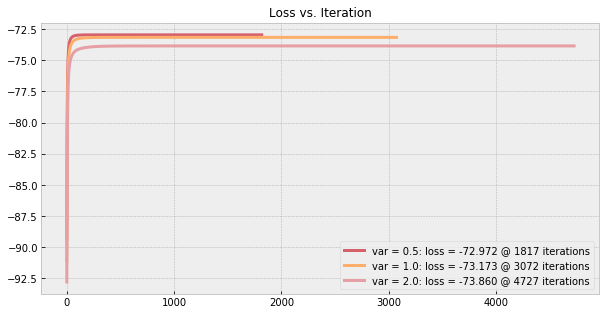

In [636]:
variances = [0.5, 1., 2.]
marginLikelihood, accuracies = [], []
plt.figure(figsize=(10,5))
BLR = BayesLogisticRegression()
for var in variances:
    print('Processing variance =', var, '...')
    BLR.setParameters(var=var)
    BLR.setPosterior(plot=True)
    marginLikelihood.append(getMarginLikelihood(BLR.wMAP, BLR.x_train, BLR.y_train, BLR.H))
    accuracies.append(getAccuracy(BLR.wMAP, BLR.x_test, BLR.y_test)/100)
    print('Accuracy = %.3f, Marginal Log Likelihood = %.3f \n'%(accuracies[-1], marginLikelihood[-1]))            
plt.show()

## Q2. Choice of Proposal Distribution & Importance sampling ========================
Importance sampling is used to estimate the most probable predictive posterior class on each element of the test set using a prior variance of σ<sup>2</sup> = 1. The test set accuracy results are reported, justifying the chosen proposal. 

The accuracy of this proposal distribution is then analyzed with the values of the posterior (at the samples) visualized the  evaluated at your samples to help justify your answer.

Note: scipy.stats module is useful for sampling.

#### The predictive distribution class

In [667]:
from matplotlib.mlab import bivariate_normal
class ImportanceSampling(BayesLogisticRegression):
    def __init__(self, meanProposal=0., varProposal=1., fromLaplace=True):
        ''' INPUTS:
            meanProposal: (D, ) array, the mean of the proposed multivariable gaussian distribution
            varProposal: (D, D), the variance of it
            fromLaplace: boolean, if so then use the MAP weight and corresponding variance for the proposal distribution
        '''
        BayesLogisticRegression.__init__(self)
        self.Prior = Normal(np.zeros(self.num_dimension), np.identity(self.num_dimension))
        self.setParameters(var=1.)
        
        if fromLaplace:
            self.setPosterior(plot=False)    
        else:
            if type(meanProposal) == int or float: 
                self.meanProposal, self.varProposal = np.ones(self.num_dimension) * meanProposal, np.identity(self.num_dimension) * varProposal
            else:
                self.meanProposal, self.varProposal = meanProposal, varProposal
    
        self.Proposal = Normal(self.meanProposal, self.varProposal)  
        np.random.seed(0)
        
        
    def getWeight(self, w):
        ''' Return: (N, ) array of floats as the weight of each sample, N being the number of w samples
        '''
        probProposal = self.Proposal.pdf(w)
        probPrior = self.Prior.pdf(w)
        if len(w.shape) == 1:
            probLikelihood = getLikelihood(w, self.x_train, self.y_train)
        else:
            probLikelihood = getLikelihood(w.T, self.x_train, self.y_train)
        return probLikelihood * probPrior / probProposal
    
    
    def getPosterior(self, w):
        ''' Return: 3 (N, ) array of floats as the weight of each sample, N being the number of w samples
        '''
        probPrior = self.Prior.pdf(w)
        if len(w.shape) == 1:
            probLikelihood = getLikelihood(w, self.x_train, self.y_train)
        else:
            probLikelihood = getLikelihood(w.T, self.x_train, self.y_train)
        normalization = np.sum(probLikelihood * probPrior)
        probPosterior = probLikelihood * probPrior / normalization
        return probPrior/np.sum(probPrior), probLikelihood/np.sum(probLikelihood), probPosterior
    

    def getPrediction(self, sampleSize=100, threshold=0.5, visualize=False):
        wList = self.Proposal.rvs(sampleSize)
        weightList = self.getWeight(wList)
        weightSum = np.sum(weightList)
        probPrediction = np.zeros(self.num_test)
        for (i, w) in enumerate(wList):
            # essentially, you make predictions on the test set with each wi, 
            # but you weight them by how likely that wi is, instead of using one particular "optimal w"
            probPrediction += getLikelihoodNew(w, self.x_test, self.y_test) * weightList[i]/weightSum
        
        y_predicted = (probPrediction >= threshold)

        accuracy = np.mean(self.y_test.T[0]==y_predicted)
        print('Accuracy = %.3f with importance sampling'%(accuracy))
        
        if visualize:
            plt.style.use('bmh')
            prior, likelihood, posterior = self.getPosterior(wList)
            proposal = self.Proposal.pdf(wList)
            proposal /= np.sum(proposal)
            f, axarr = plt.subplots(2, 3, figsize=(15,8))
            f.suptitle('Importance Sampling on each dimension or w')
            for i in range(5):
                w = wList[:, i]
                x, y = 0, 0
                if i >= 3: x = 1
                if (i+1)%2 == 0: y = 1
                if (i+1)%3 == 0: y = 2
                axarr[x, y].scatter(w, prior, alpha=0.8, color=_COLORS[4], s=10, label = 'Prior')
                axarr[x, y].scatter(w, likelihood, alpha=0.4, color=_COLORS[1], s=10, label = 'Likelihood')
                axarr[x, y].scatter(w, posterior, alpha=0.1, color=_COLORS[0], s=10, label = 'Posterior')                
                # axarr[x, y].scatter(w, proposal, alpha=1, color='w', s=10, label = 'Proposal')                
                axarr[x, y].set_title('Posterior vs. w%d'%(i))
                axarr[x, y].set_ylim([0, 0.003])
                axarr[x, y].legend()
            plt.show()

MAP weight: [-0.87805271  0.29302957 -1.2347739   0.67815586 -0.89401743]
Accuracy = 0.733 with importance sampling


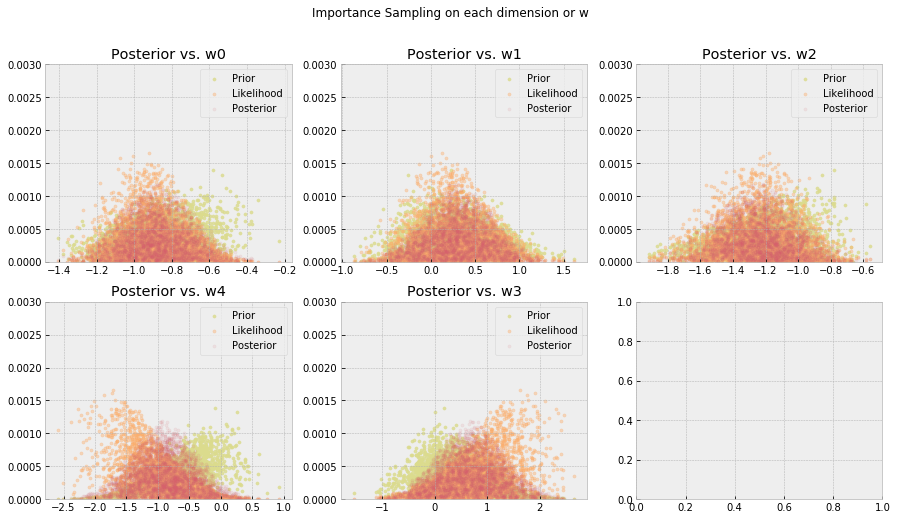

In [668]:
Test = ImportanceSampling(fromLaplace=True)
Test.getPrediction(3000, visualize=True)

Accuracy = 0.733 with importance sampling


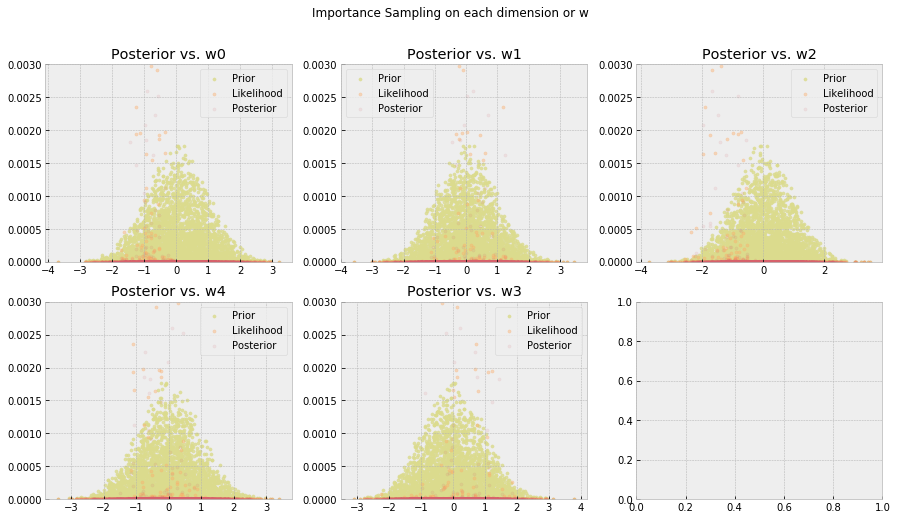

In [669]:
Test = ImportanceSampling(fromLaplace=False)
Test.getPrediction(3000, visualize=True)

## Metropolis-Hastings MCMC Sampling
MCMC is used to estimate the most probable predictive posterior class on each element of the test set using a prior variance of σ<sup>2</sup> = 1. 

Use the proposal _q(w<sup>(\*)</sup>|w<sup>(i)</sup>) = N(w<sup>(\*)</sup>|w<sup>(i)</sup>, σ<sub>p</sub><sup>2</sup>I􏰁)_, and burn-in 1000 iterations. After the burn-in, sample for an additional 10000 iterations, thinning by collecting every 100th sample. Choose and report your value of σ<sub>p</sub><sup>2</sup>, and report your test set accuracy results. 

Plot the predictive posterior class-conditional probability samples (i.e. plot Pr(y<sup>(\*)</sup> = 1|x<sup>(\*)</sup>,w<sup>(i)</sup>), where w<sup>(i)</sup> ∼ Pr(w|X,y) for i = 1,...,S) for the 9th, and the 10th flowers in the testing dataset2 as a histogram. Discuss the visualization. What valuable information from these figures would be lost if a frequentist approach were taken?

In [674]:
from scipy.stats import norm
class MCMC(BayesLogisticRegression):
    def __init__(self, var=1.):
        BayesLogisticRegression.__init__(self)
        self.Prior = Normal(np.zeros(self.num_dimension), np.identity(self.num_dimension))
        self.w = [np.array([0, 0, 0, 0, 0])]
        self.wThin, self.iThin = [], []
        self.countRejected = 0
        self.var = var
        np.random.seed(99)
        
    def getProposalSampler(self, w0):
        return w0 + np.random.randn(*w0.shape)
    
    def getProposalPDF(self, w0, w1):
        mean, var = np.zeros(self.num_dimension), np.identity(self.num_dimension)*self.var
        return Normal(mean, var).pdf(w1-w0)
    
    def getTargetPDF(self, w):
        return getLikelihood(w, self.x_train, self.y_train)*self.Prior.pdf(w)
    
    def MCMCStep(self, w0):
        """
        Performs a single Metropolis-Hastings MCMC step.
        Inputs:
            w0 : vector of parameters before step
            proposal_sampler : function which takes w and returns a random sample from 
                the proposal distribution
            proposal_pdf : function that takes a, and the b, and returns the 
                proposal probability density function evaluated at q(a|b).
            target_pdf : function that takes w and returns the target probability density 
                function evaluated at w. This PDF may be unnormalized.
        Returns:
            w1 : vector of parameters after step
        """
        u = np.random.rand()
        w1 = self.getProposalSampler(w0) # propose an update
        if u < np.minimum(1, (self.getTargetPDF(w1)*self.getProposalPDF(w0,w1)) / (self.getTargetPDF(w0)*self.getProposalPDF(w1,w0))):
            pass # keep the proposal
        else:
            w1 = w0 # reject the proposal
            self.countRejected += 1
        return w1
    
    def MCMCWalk(self, trace=True):
        for i in range(0, 11000):
            self.w.append(self.MCMCStep(self.w[-1]))
            if i >= 1000 and (i%100) == 0:
                self.iThin.append(i - 999)
                self.wThin.append(self.w[-1])
                if trace: print('Round', i, self.wThin[-1])
        
    def prediction(self, trace=False):
        self.MCMCWalk(trace)
        
        # Accuracy
        probPrediction, count = np.zeros(self.num_test), len(self.wThin)
        for w in self.wThin:
            probPrediction += getLikelihoodNew(w, self.x_test, self.y_test)
        y_predicted = (probPrediction/count >= 0.5)
        accuracy = np.mean(self.y_test.T[0]==y_predicted)
        print('Accuracy = %.3f with MCMC sampling'%(accuracy))
        print('Rejection rate = %.2f at variance %.2f'%(self.countRejected/11000, self.var))
       
        # Histogram
        self.wThin = np.array(self.wThin)
        xtest, ytest = self.x_test[[9, 10]], self.y_test[[9, 10]].T[0]
        yProb = getSigmoidProbability(self.wThin.T, xtest)
        yPred = (np.mean(yProb, axis=1) >= 0.5)
        
        Prob9, Prob10 = yProb[0], yProb[1]
        plt.style.use('bmh')
        f, axarr = plt.subplots(1, 2, figsize=(14,5))
        f.suptitle('Predictive posterior class-conditional probability samples')
        axarr[0].hist(Prob9, bins=7, color=_COLORS[0])   
        axarr[0].set_title('9th datapoint from test set, avg = %.3f' % np.mean(Prob9))
        axarr[0].set_xlim([0, 1.])  
        axarr[1].hist(Prob10, bins=7, color=_COLORS[0])   
        axarr[1].set_title('10th datapoint from test set, avg = %.3f'% np.mean(Prob10))
        axarr[1].set_xlim([0, 1.])
        plt.show()

Accuracy = 0.733 with MCMC sampling
Rejection rate = 0.65 at variance 0.05


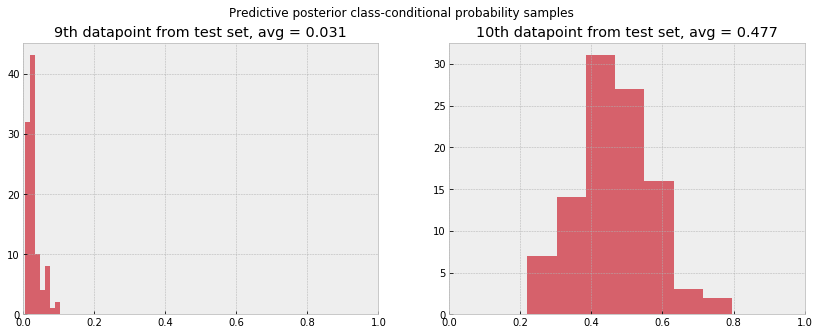

In [675]:
Q3 = MCMC(var=1.0)
Q3.prediction(trace=False)